In [1]:
import torch
from torch import nn
from matplotlib import pyplot as plt
import numpy as np
from tqdm import trange
import gzip
import requests as r

In [2]:
urls = ['http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
       'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
       'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
       'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz']

def download(urls):
    for url in urls:
        buf = r.get(url).content
        with open('./downloads/' + url.split('/')[-1], 'wb') as f:
            f.write(bytearray(buf))
        
download(urls)

paths = {
    'test_imgs': 't10k-images-idx3-ubyte.gz',
    'test_labels': 't10k-labels-idx1-ubyte.gz',
    'train_imgs': 'train-images-idx3-ubyte.gz',
    'train_labels': 'train-labels-idx1-ubyte.gz'
}
for path in paths:
    paths[path] = './downloads/' + paths[path]

try:
    for _, arr in data.items():
        print(arr.shape)
except NameError:
    data = dict()
    for name, path in paths.items():
        with gzip.open(path) as f:
            if 'imgs' in name:
                data[name] = np.frombuffer(f.read(), 'B', offset=16).reshape((-1, 1, 28, 28))
            else:
                data[name] = np.frombuffer(f.read(), 'B', offset=8)

In [3]:
test_imgs = data['test_imgs']
test_labels = data['test_labels']
train_imgs = data['train_imgs']
train_labels = data['train_labels']

In [4]:
test_imgs.dtype

dtype('uint8')

In [5]:
class BobNet(nn.Module):
    def __init__(self):
        super(BobNet, self).__init__()
        self.hid = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )
    def forward(self, x):
        return self.hid(x)

Loss= 0.06, Acc= 0.97: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:05<00:00, 942.21it/s]


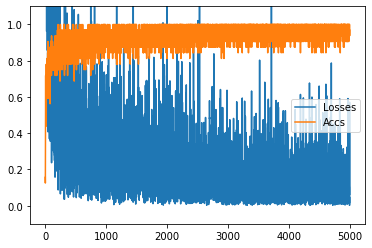

In [6]:
model = BobNet()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0)
epochs = 5000
BS = 32

losses, accs  = [], []
for i in (t := trange(epochs)):
    samp = np.random.randint(0, train_imgs.shape[0], size=BS)
    X = torch.tensor(train_imgs[samp]).float()
    Y = torch.tensor(train_labels[samp]).long()
    
    optimizer.zero_grad()
    pred = model(X)
    loss = loss_fn(pred, Y)
    Y_hat = torch.argmax(pred, dim=1)
    acc = (Y_hat == Y).float().mean()
    loss.backward()
    optimizer.step()
    loss, acc = loss.item(), acc.item()
    losses.append(loss)
    accs.append(acc)
    t.set_description(f'Loss={loss: .2f}, Acc={acc: .2f}')

plt.ylim(-.1, 1.1)
plt.plot(losses, label='Losses')
plt.plot(accs, label='Accs')
plt.legend()
plt.show()

In [186]:
class Linear():
    def __init__(self, in_dim, out_dim):
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.weight = np.empty((out_dim, in_dim))
        self.bias = np.empty((out_dim))
        
    def forward(self, x):
        return np.dot(self.weight, x) + self.bias
    
    def __call__(self, x):
        return self.forward(x)
    def __str__(self):
        return f'Linear(in_features={self.in_dim}, out_features={self.out_dim})'
    __repr__=__str__
        
class ReLU():
    def forward(self, x):
        x[x < 0] = 0
        return x
    
    def __call__(self, x):
        return self.forward(x)
    def __str__(self):
        return 'ReLU()'
    __repr__=__str__
        
class Flatten():
    def forward(self, x):
        return x.reshape((-1))
    
    def __call__(self, x):
        return self.forward(x)
    def __str__(self):
        return 'Flatten()'
    __repr__=__str__

class Sequential():
    def __init__(self, *args):
        self.layers = args

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def __call__(self, x):
        return self.forward(x)
    def __getitem__(self, i):
        return self.layers[i]
    def __str__(self):
        str = 'Sequentail(\n'
        for i, layer in enumerate(self.layers):
            str += f'  ({i}): {repr(layer)}\n'
        str += ')'
        return str
    __repr__=__str__

In [191]:
class RawNet():
    def __init__(self):
        self.hid = Sequential(
            Flatten(),
            Linear(28*28, 128),
            ReLU(),
            Linear(128, 10),
        )
    def forward(self, x):
        return self.hid(x)
    def __call__(self, x):
        return self.forward(x)
raw_model = RawNet()
print(raw_model.hid)

Sequentail(
  (0): Flatten()
  (1): Linear(in_features=784, out_features=128)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=10)
)


In [193]:
raw_model.hid[1].weight = model.hid[1].weight.clone().detach().numpy()
raw_model.hid[1].bias = model.hid[1].bias.clone().detach().numpy()
raw_model.hid[3].weight = model.hid[3].weight.clone().detach().numpy()
raw_model.hid[3].bias = model.hid[3].bias.clone().detach().numpy()
raw_model.hid[1].weight.shape

(128, 784)

In [196]:
np.argmax(raw_model(test_imgs[0].reshape((28,28))))

7

tensor(7)

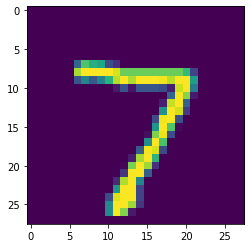

In [96]:
plt.imshow(test_imgs[0].reshape((28,28)))
torch.argmax(model(torch.tensor(test_imgs[0].reshape((-1,1,28,28))).float()))